In questo notebook mostriamo come generiamo il battlefield, la zona in cui il nostro agente troverà oro e mostri a difenderlo.
Per il battlefield abbiamo scelto 5 mappe possibili per ogni livello con una generazione di mostri e monete casuale, l'obbiettivo è spawnare vicino a mostri più forti più monete e vicino a quelli deboli poche monete.
In ogni possibile livello può capitare:  
-Boss room, dove sarà presente un solo nemico, il più forte per quel livello che difenderà tante monete.  
-Maze room, l'agente dovrà eseguire del pathfinding per trovare l'uscita e i gold, sparsi casualmente all'interno del livello  
-Room, una stanza aperta con nemici e monete spawnate nelle vicinanze  
-Mini boss room: la stanza mostrata durante la presentazione, miniboss a difendere tanti gold, nemici a difendere l'uscita e altri nemici a difendere i gold  
-BONUS ROOM: una stanza molto rara, (1/100) dove saranno presenti solo monete, un Coridor

In [140]:
import gym
import minihack
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import sys
from io import StringIO
from minihack import LevelGenerator
from minihack.envs.room import MiniHackRoom15x15
from minihack.envs.corridor import MiniHackCorridor
from minihack.envs.mazewalk import MiniHackMazeWalk9x9


Aggiungiamo la funzione per visualizzare le mappe

In [141]:
def render_des_file(des_file):
    env = gym.make('MiniHack-Skill-Custom-v0',
               character="sam-hum-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel'),
               des_file=des_file)

    obs = env.reset()
    env.render()
    plt.imshow(obs['pixel'][0:900, 0:900])

Ora aggiungiamo le uniche due mappe custom che utilizziamo, la miniboss room e la boss room.

In [152]:
minibossmap="""||||||||||||
|..........|
|.||||||...|
|.|........|
|.|||||....|
|.....|....|
|||||||....|
|..........|
|.|||||....|
|.|...|....|
|.|...|....|
|.|...|....|
|||.||||...|
|......|...|
|......|...|
|..........|
|......|...|
||||||||||||"""

riferimentiminibossmap="""
STAIR:(10, 1),down
soldi (5 gold)
MONSTER: random, random, (3,10)
MONSTER: random, random, (4,10)
MONSTER: random, random, (5,10)
MONSTER: random, random, (5,5)
nemici deboli 
MONSTER: random, random, (9,1)
MONSTER: random, random, (10,2)
MONSTER: random, random, (1,3)
miniboss
MONSTER: random, random, (3,14)
porta
MONSTER: random, random, (3,12)
"""




bossmap="""      |||||      
      |...|      
      |...|      
||||||||.||||    
|...|.......|    
|...|.......|||||
|...|.......|...|
|...............|
|...|.......|...|
|...|.......|||||
|...|.......|    
|||||||||||||"""    

riferimentibossroom="""
scale:(8, 1),down
spawn: (1,7,1,7),(2,8,2,8)
porte
sinistra: random, random, (4,7)
su: random, random, (8,3)
destra: random, random, (12,7)

boss: random, random, (9,7)
"""

roommap="""|||||||||||||||
|.............|
|.............|
|.............|
|.............|
|.............|
|.............|
|.............|
|.............|
|.............|
|.............|
|.............|
|.............|
|||||||||||||||"""

mazebasemap="""|||||||||||||||||||||||||
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|.                     .|
|||||||||||||||||||||||||"""





Ora prendiamo le mappe dagli env predefiniti e definiamo la generazione.  
La prima è la bonus room, un piccola stanza con 15 gold nel punto di arrivo.

In [ ]:
def bonusroom():
    lvl=LevelGenerator(lit=True,flags=['premapped'],w=5,h=3)
    lvl.wallify()
    lvl.set_start_pos((0,0))
    lvl.add_stair_down(place=(4,0))
    lvl.add_line("GOLD: 5,(1,1)")
    lvl.add_line("GOLD: 5,(2,1)")
    lvl.add_line("GOLD: 5,(3,1)")
    
    return lvl.get_des()

Boss room: una stanza con un nemico più potente del normale e una stanza con 20 gold per la sua sconfitta.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                    -----                                       
                                    |.>.|                                       
                                    |...|                                       
                              --------+----                                     
                              |...|.......|                                     
                              |...|.......|----                                 
                           

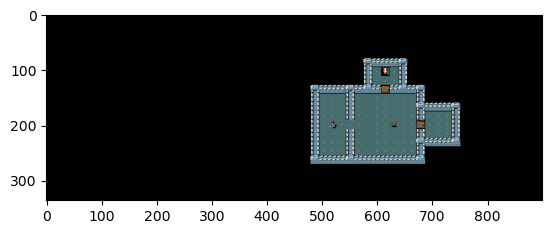

In [186]:
def bossroomdes(levelnumber):
    lvl=LevelGenerator(map=bossmap,lit=True,flags=['premapped'])
    lvl.set_start_pos((2,7))
    lvl.add_stair_down(place=(8, 1))
    lvl.add_door("closed", place=(8,3))
    lvl.add_door("closed", place=(12,7))

    lvl.add_line("GOLD: 5,(14,7)")
    lvl.add_line("GOLD: 5,(15,6)")
    lvl.add_line("GOLD: 5,(15,7)")
    lvl.add_line("GOLD: 5,(15,8)")
    #AGGIUNGI IL BOSS (9,7)
    lvl.add_monster(name='bat',place=(9,7))
    
    return lvl.get_des()

render_des_file(bossroomdes(1))

Mini boss room: la stanza mostrata nella presentazione, la più probabile, mob da battere obbligatoriamente per passare e miniboss a scelta per ottenere più monete.

In [ ]:
def minibossroomdes(levelnumber):
    lvl=LevelGenerator(map=minibossmap,lit=True,flags=['premapped'])
    lvl.set_start_pos((1,11))
    lvl.add_stair_down(place=(10, 1))
    
    #ZONA MOB
    #MOSTRI (8,1) (9,2) (10,3)
    
    lvl.add_door("closed", place=(7,1))
    #MOB (1,1)
    lvl.add_line("GOLD: 5,(5,5)")


    #ZONA MINIBOSS
    #MINIBOSS STA A (3,13)
    lvl.add_door("closed", place=(3,12))
    lvl.add_door("closed", place=(7,15))
    #MINIBOSS REWARD
    lvl.add_line("GOLD: 5,(3,10)")
    lvl.add_line("GOLD: 5,(4,10)")
    lvl.add_line("GOLD: 5,(5,10)")
    #lvl.add_line("GOLD: 5,(15,8)")
    return lvl.get_des()

Common room: stanza senza ostacoli, mob sparsi (pseudo)casualmente e 20 gold sparsi.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                ---------------                                 
                                |..........B.>|                                 
                                |.$...........|                                 
                                |......B......|                                 
                                |.............|                                 
                                |....B........|                                 
                           

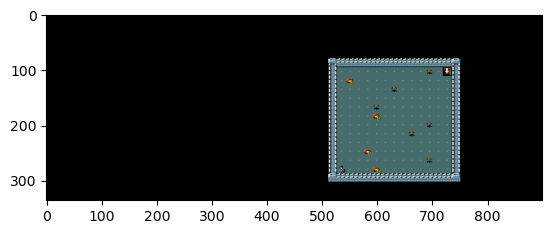

In [189]:
def roomroomdes(seed,levelnumber):
    lvl=LevelGenerator(map=roommap,lit=True,flags=['premapped'])
    lvl.set_start_pos((1,12))
    lvl.add_stair_down(place=(13, 1))
    #AGGIUNGI MOB RANDOMICAMENTE
    random.seed(seed)

    #RANDOMICITÀ MUTUALMENTE ESCLUSIVA----- 
    pseudoarray=[]
    for i in range(1,13):
        pseudoarray.append(i)
    pseudomatrix=[]
    for i in range(0,10):
        pseudomatrix.append(pseudoarray)
    temporaryseed=seed
    def pseudorandompos (seed:(int))->(int,int):
        random.seed(seed)
        a=random.randint(0,10)
        b=random.choice(pseudomatrix[a])
        pseudomatrix[a].pop(pseudomatrix[a].index(b))
        return (a+2,b)
    #-------------------------------    

    for i in range(0,4):
        lvl.add_line("GOLD: 5,"+str(pseudorandompos(temporaryseed)))
        temporaryseed=temporaryseed+1

    for i in range(0,6):
        #AGGIUNGI MOB IN BASE AL LIVELLO
        lvl.add_monster(name='bat',place=pseudorandompos(temporaryseed))
        temporaryseed=temporaryseed+1
  
    return lvl.get_des()

render_des_file(roomroomdes(1,1))



Maze room: pathfinding in un piccolo labirinto, all'arrivo sono presenti 15 gold come ricompensa.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                          ---                   ---                             
                          |.---------------------.|                             
                          |....|.....|............|                             
                          |..|.|.|.|.-------.----.|                             
                          |@.|.|.|.|.......|.|...>|                             
                          |.-|.--|.-------.|.|.|..|                             
                          |

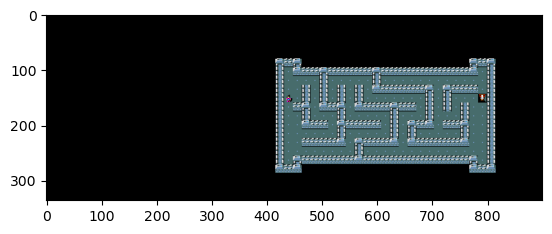

In [183]:

def mazeroomdes():
    lvl=LevelGenerator(map=mazebasemap,lit=True,flags=['premapped'])
    lvl.set_start_pos((1,4))

    lvl.add_stair_down(place=(23, 4))
    
    lvl.add_mazewalk(coord=(1,4), dir='east')

    lvl.add_line("GOLD: 5,(23,5)")
    lvl.add_line("GOLD: 5,(23,6)")
    lvl.add_line("GOLD: 5,(23,7)")
    lvl.wallify()
    return lvl.get_des()

render_des_file(mazeroomdes(4))


Ora si generano i battlefield sempre in base al seed, come negli shop, questa volta con le seguenti probabilità:  
Common Room = 50% | Miniboss Room = 30% | Boss Room = 10% | Maze Room = 9,5% | Bonus Room=0,5%  
Nel primo livello è assicurata una Room e nell'ultimo una Boss Room.



In [ ]:
def creabattlefield(levelnumber:int ,startingseed:int ):
    if levelnumber==1:
        return roomroomdes(startingseed, levelnumber)
    elif levelnumber==5:
        return bossroomdes(5)
    else:
        random.seed(startingseed*levelnumber)
        choice=random.randint(0,200)
        if(choice<=100):
            return roomroomdes(startingseed,levelnumber)
        elif(choice<=160):
            return minibossroomdes(levelnumber)
        elif(choice<=180):
            return bossroomdes(levelnumber)
        elif(choice<=199):
            return mazeroomdes()
        else:
            return bonusroom
    
#UTILIZZARE UN SEED COMPRESO TRA 0 e 200 (lo stesso utilizzato per lo shop).
creabattlefield(1,1)

TODO: AGGIUNGERE MOB, MINIBOSS E BOSS CHE DIPENDONO DAL LIVELLO, NON TUTTI PIPISTRELLI